<br><br>
<font size=5>Model selection</font>
<br>
<br>
<br>

<br>
<font size=4>Переобучение многочленов</font>
<br><br>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

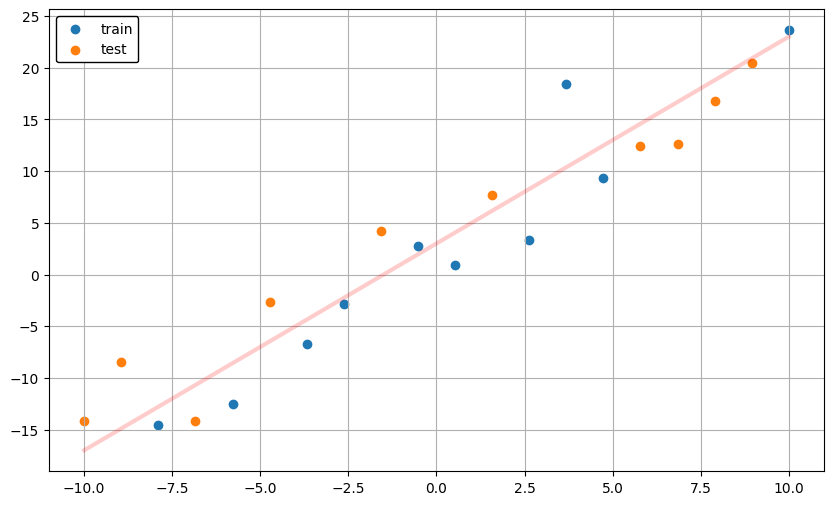

In [2]:
X = np.linspace(-10, 10, 20)
y = 2 * X + 3 + np.random.randn(20) * 3
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(X_train, y_train, label='train')
ax.scatter(X_test, y_test, label='test')
ax.plot(X, 2 * X + 3, color='red', lw=3, alpha=0.2)
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')

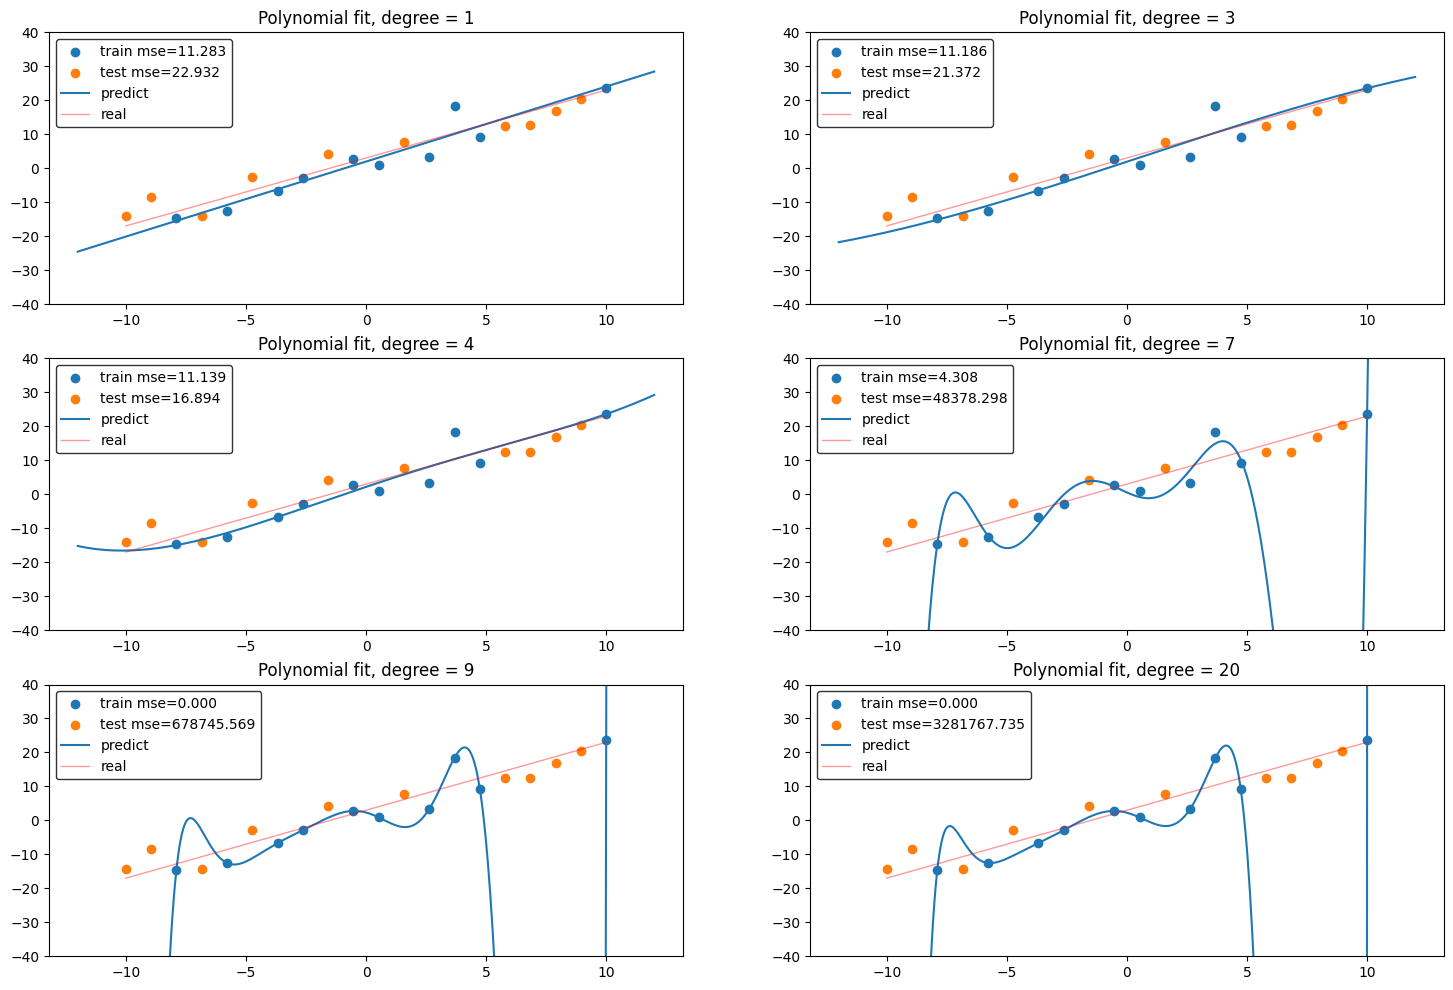

In [3]:
grid = np.linspace(-12, 12, 500)

fig, ax = plt.subplots(3, 2, figsize=(18, 12))
ax = ax.ravel()

for i, deg in enumerate([1, 3, 4, 7, 9, 20]):
    poly = np.polyfit(X_train, y_train, deg)
    ax[i].set_title(f'Polynomial fit, degree = {deg}')
    ax[i].scatter(X_train, y_train,
                  label=f'train mse={mean_squared_error(y_train, np.polyval(poly, X_train)):.3f}')
    ax[i].scatter(X_test, y_test,
                  label=f'test mse={mean_squared_error(y_test, np.polyval(poly, X_test)):.3f}')
    ax[i].set_ylim(-40, 40)
    ax[i].plot(grid, np.polyval(poly, grid), label='predict')
    ax[i].plot(X, 2 * X + 3, color='red', lw=1, alpha=0.4, label='real')
    legend_box = ax[i].legend().get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('black')
fig.show()

<br>
<font size=5>Выбор оптимальной модели</font>
<br><br>

In [4]:
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                   sep=', ', names=columns.split())

In [5]:
data = data.replace('?', np.nan)
data.dropna()
data['salary'] = data['salary'].map(lambda x: x=='>50K')
numerical_data = data[[col for col in data
                       if data[col].dtype in ['int64', 'float64']]]
categorical_data = data[[col for col in data
                         if data[col].dtype == 'object']]

data['education'].nunique()

16

In [6]:
dummy_features = pd.get_dummies(categorical_data)

In [7]:
X = pd.concat([numerical_data, dummy_features], axis=1)
X_origin = data.iloc[:, :-1]
y = data['salary']
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X.shape, X_origin.shape

((32561, 105), (32561, 14))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Поиск оптимального гиперпараметра модели.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [12]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            cv=5,
                            scoring='f1',
                            n_jobs=-1,
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15, 8))
        plt.title(f'choose {param_name}')
        
        if (param_scale == 'log'):
            plt.xscale('log')
            
        plt.plot(grid, means, label='mean values of score', color='red', lw=3)
        plt.fill_between(grid, means - error, means + error,
                        color='green', label='filled area between errors')
        legend_box = plt.legend().get_frame()
        legend_box.set_facecolor('white')
        legend_box.set_edgecolor('black')
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


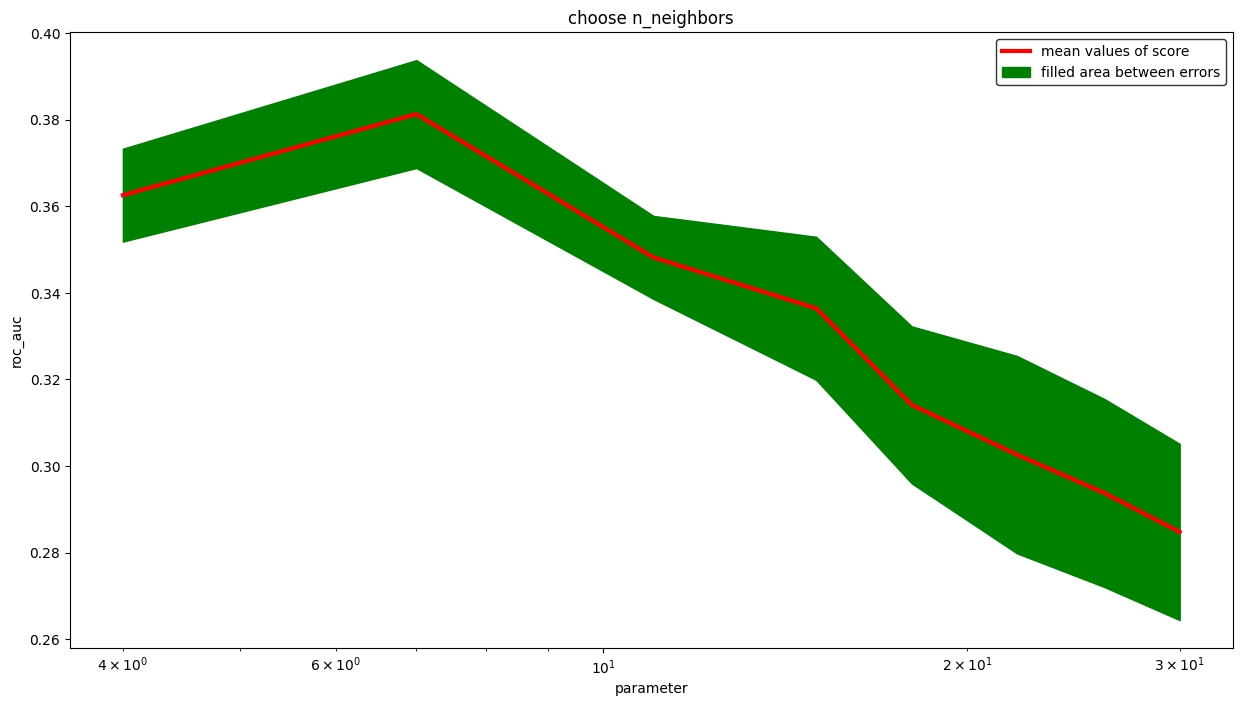

Fitting 5 folds for each of 29 candidates, totalling 145 fits


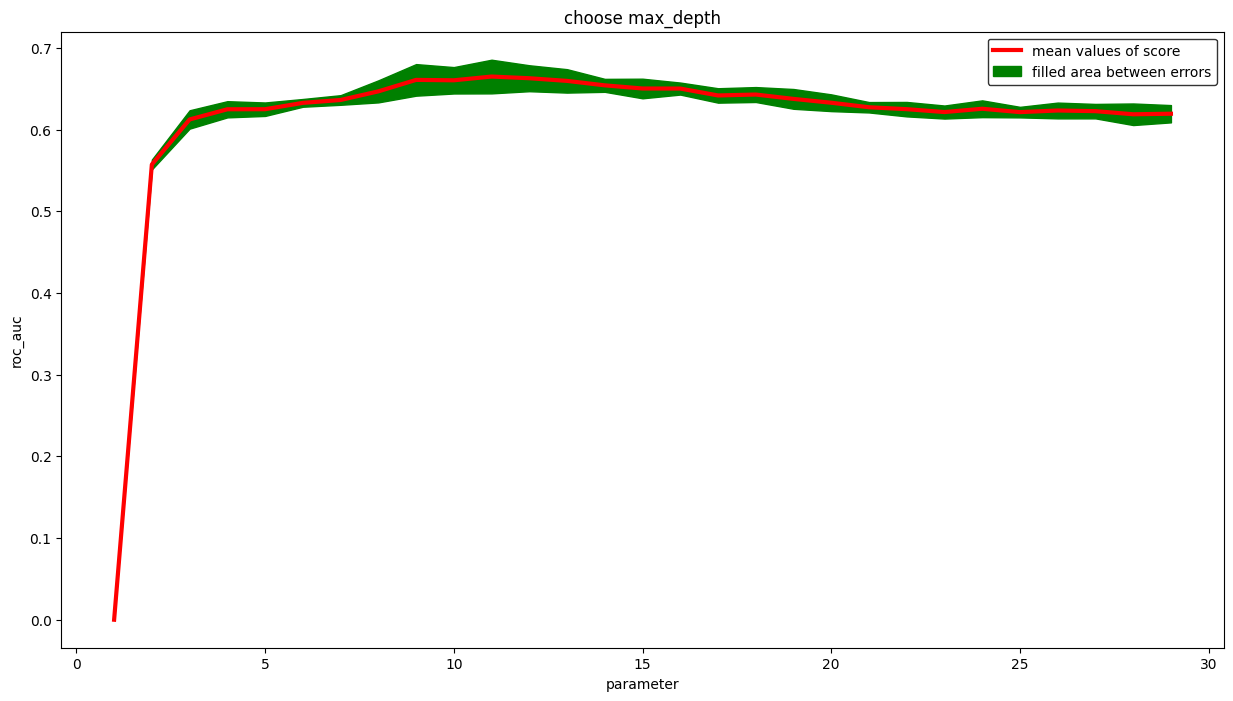

In [15]:
for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

<br>
<font size=4>Random Forest подбор параметра n_estimators.</font>
<br><br>
Подберем параметр n_estimators для Random Forest. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменится. Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большего количества деревьев, а затем рассмотреть подмножества нажного размера из исходного множества деревьев.
<br><br>
<b>Random Forest является примером Ансамблей, а именно в нем заложен метод Беггинг.</b>
<br><br>

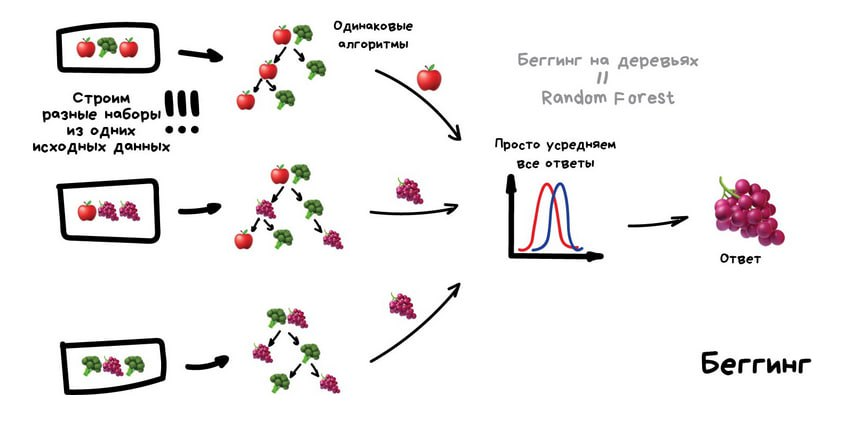
<br>

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [18]:
max_trees = 100
values = np.arange(max_trees) + 1
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
global_scores = []

for train_indices, test_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train.iloc[train_indices]
    y_train_kf = y_train.iloc[train_indices]
    
    X_test_kf = X_train.iloc[test_indices]
    y_test_kf = y_train.iloc[test_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]
        predict = thinned_forest.predict_proba(X_test_kf)[:, 1]
        scores.append(roc_auc_score(y_test_kf, predict))
        
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

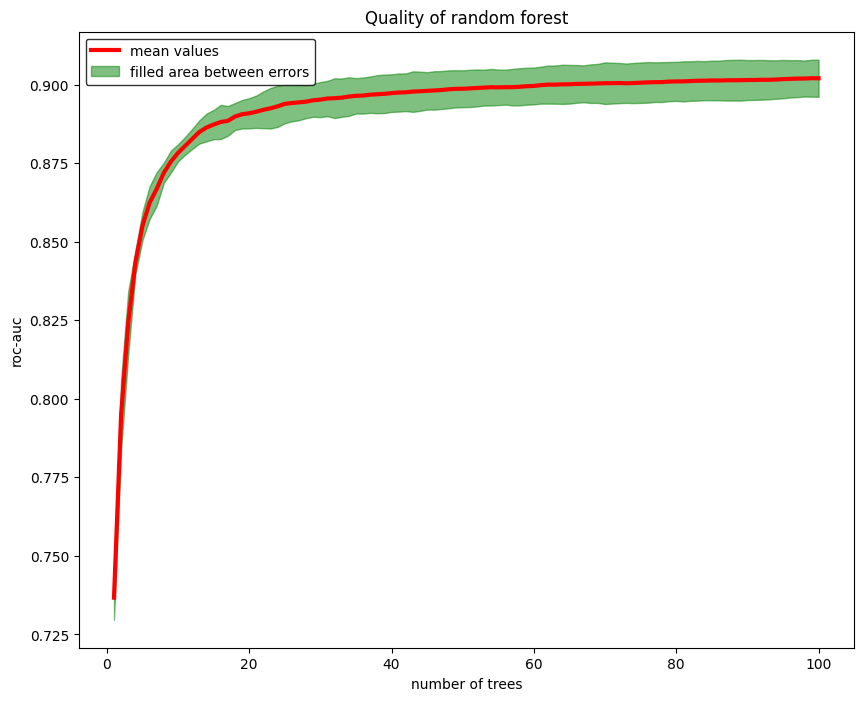

In [19]:
mean_cross_test_score = global_scores.mean(axis=0)
std_cross_test_score = global_scores.std(axis=0)

plt.figure(figsize=(10, 8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_test_score, label='mean values', color='red', lw=3)
plt.fill_between(values,
                 mean_cross_test_score - 2 * std_cross_test_score,
                 mean_cross_test_score + 2 * std_cross_test_score,
                 color='green',
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend().get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

<br>
<center><font size=4>Нормировка признаков</font></center>
<br><br>
<center>StandardScaler выполняет преобразование<center> <br>
$$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$
<br><br>

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5; 1/8] START n_neighbors=4...............................................
[CV 3/5; 1/8] END ................n_neighbors=4;, score=0.359 total time=  31.9s
[CV 1/5; 2/8] START n_neighbors=7...............................................
[CV 1/5; 2/8] END ................n_neighbors=7;, score=0.373 total time=   4.1s
[CV 1/5; 3/8] START n_neighbors=11..............................................
[CV 1/5; 3/8] END ...............n_neighbors=11;, score=0.348 total time=   3.9s
[CV 1/5; 4/8] START n_neighbors=15..............................................
[CV 1/5; 4/8] END ...............n_neighbors=15;, score=0.345 total time=   3.6s
[CV 4/5; 4/8] START n_neighbors=15..............................................
[CV 4/5; 4/8] END ...............n_neighbors=15;, score=0.322 total time=   3.2s
[CV 3/5; 5/8] START n_neighbors=18..............................................
[CV 3/5; 5/8] END ...............n_neighbors=18;,

[CV 1/5; 1/8] START n_neighbors=4...............................................
[CV 1/5; 1/8] END ................n_neighbors=4;, score=0.351 total time=  32.1s
[CV 3/5; 2/8] START n_neighbors=7...............................................
[CV 3/5; 2/8] END ................n_neighbors=7;, score=0.367 total time=   3.8s
[CV 4/5; 2/8] START n_neighbors=7...............................................
[CV 4/5; 2/8] END ................n_neighbors=7;, score=0.382 total time=   3.4s
[CV 3/5; 3/8] START n_neighbors=11..............................................
[CV 3/5; 3/8] END ...............n_neighbors=11;, score=0.338 total time=   3.8s
[CV 2/5; 4/8] START n_neighbors=15..............................................
[CV 2/5; 4/8] END ...............n_neighbors=15;, score=0.333 total time=   3.6s
[CV 1/5; 5/8] START n_neighbors=18..............................................
[CV 1/5; 5/8] END ...............n_neighbors=18;, score=0.322 total time=   3.7s
[CV 5/5; 5/8] START n_neighb

[CV 2/5; 1/8] START n_neighbors=4...............................................
[CV 2/5; 1/8] END ................n_neighbors=4;, score=0.364 total time=  31.7s
[CV 5/5; 1/8] START n_neighbors=4...............................................
[CV 5/5; 1/8] END ................n_neighbors=4;, score=0.382 total time=   4.2s
[CV 2/5; 3/8] START n_neighbors=11..............................................
[CV 2/5; 3/8] END ...............n_neighbors=11;, score=0.352 total time=   3.8s
[CV 4/5; 3/8] START n_neighbors=11..............................................
[CV 4/5; 3/8] END ...............n_neighbors=11;, score=0.339 total time=   3.5s
[CV 3/5; 4/8] START n_neighbors=15..............................................
[CV 3/5; 4/8] END ...............n_neighbors=15;, score=0.319 total time=   3.3s
[CV 2/5; 5/8] START n_neighbors=18..............................................
[CV 2/5; 5/8] END ...............n_neighbors=18;, score=0.310 total time=   3.5s
[CV 1/5; 6/8] START n_neighb

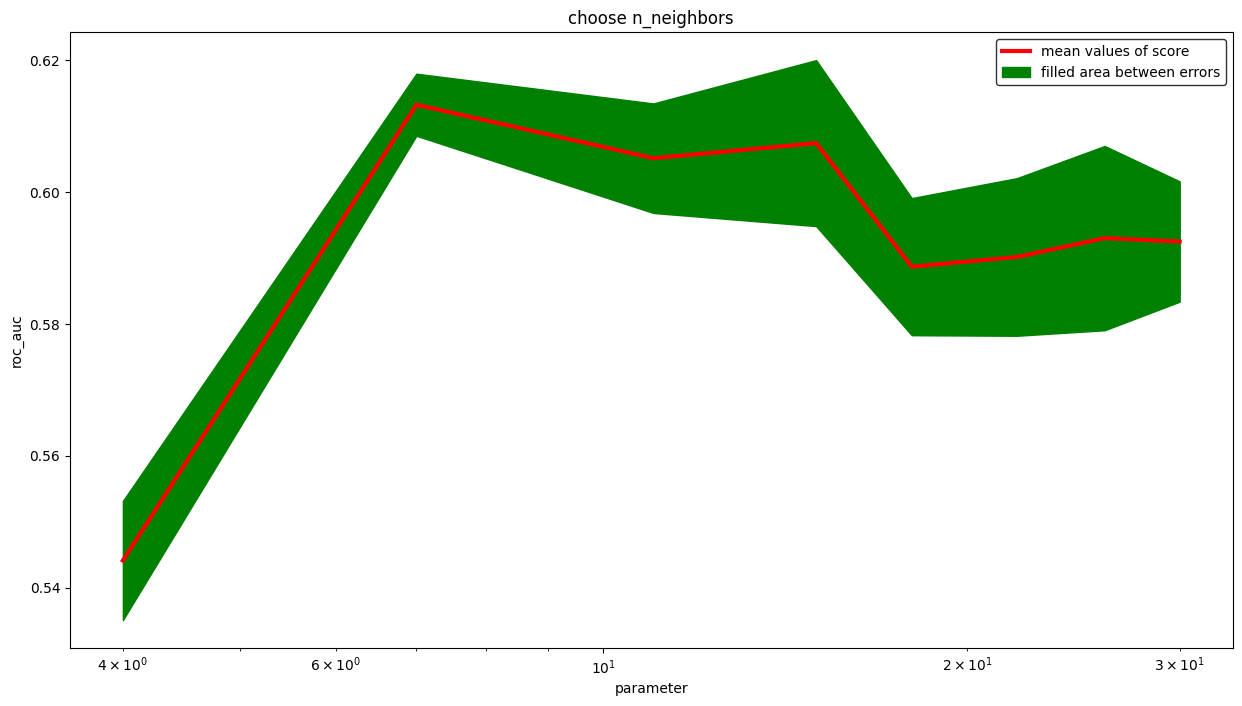

(array([0.54411732, 0.61321811, 0.60511   , 0.60739809, 0.5886685 ,
        0.59014128, 0.59299713, 0.59247941]),
 array([0.00903476, 0.0047064 , 0.00830297, 0.01258278, 0.01039212,
        0.01194729, 0.01396816, 0.00912238]))

In [22]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors',
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log')

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [25]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

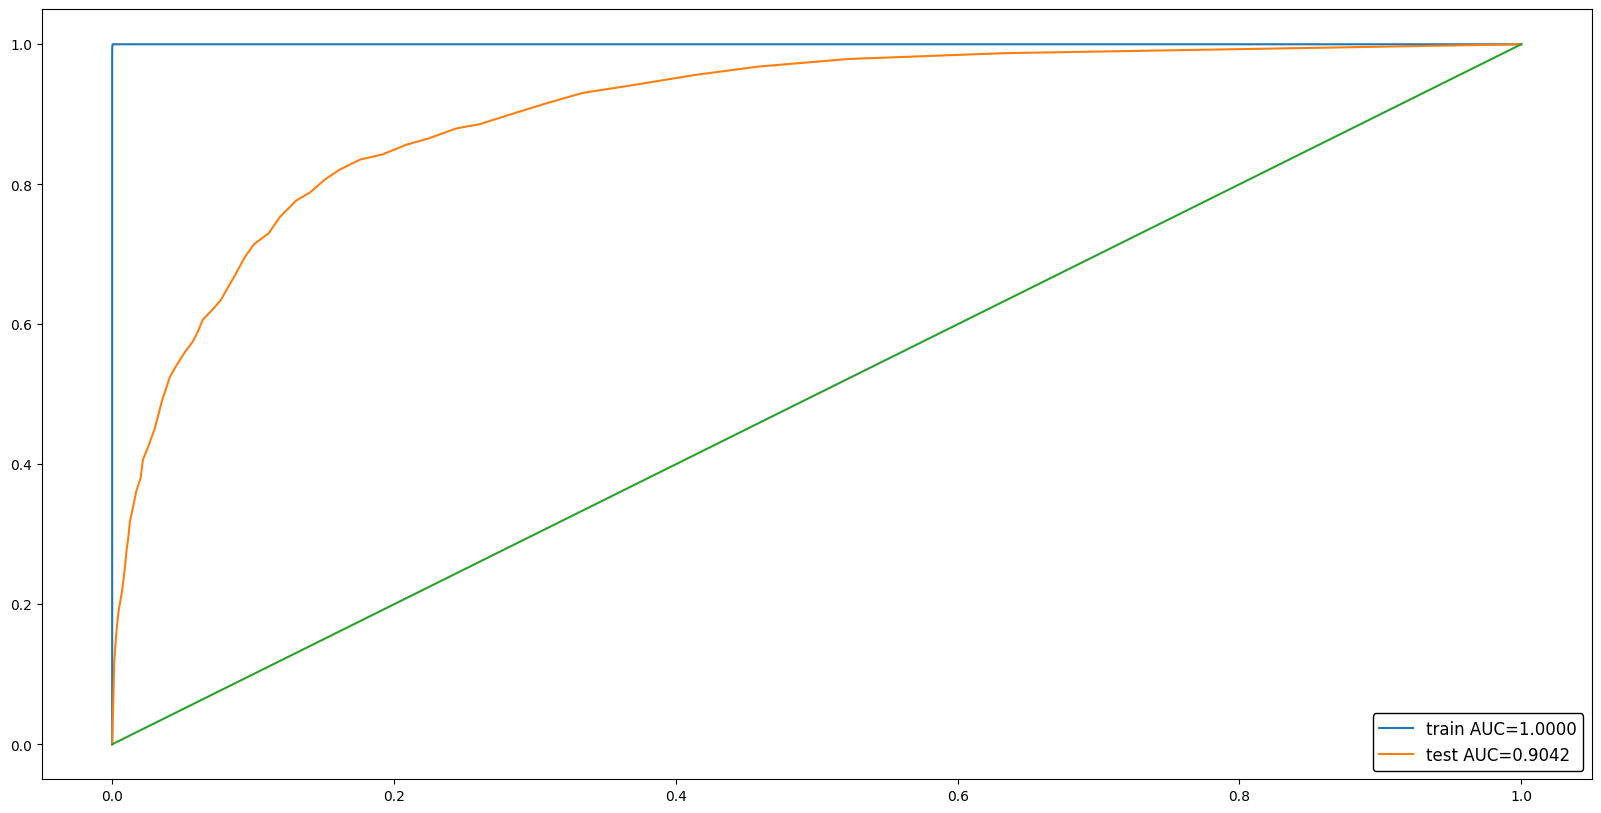

In [26]:
plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

<br>
<font size=5>Стекинг</font>
<br><br>

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве признаков объектов.<br>
Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде<br>
алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.
<br><br>
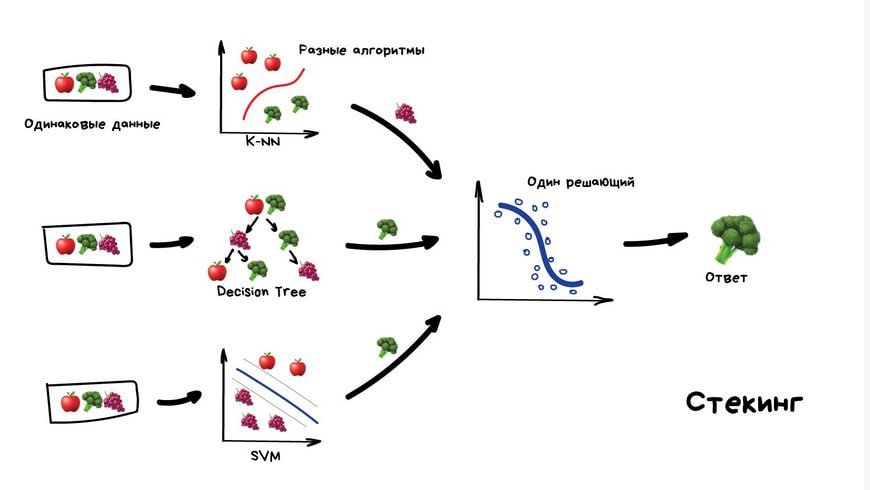
<br>
<br>

In [27]:
from sklearn.model_selection import cross_val_predict

In [60]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answer = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answer, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answer = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answer, model.predict(X_test)[:, 1]

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [62]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [63]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [64]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_pred = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_pred = stacking_model.predict_proba(meta_features_test)[:, 1]

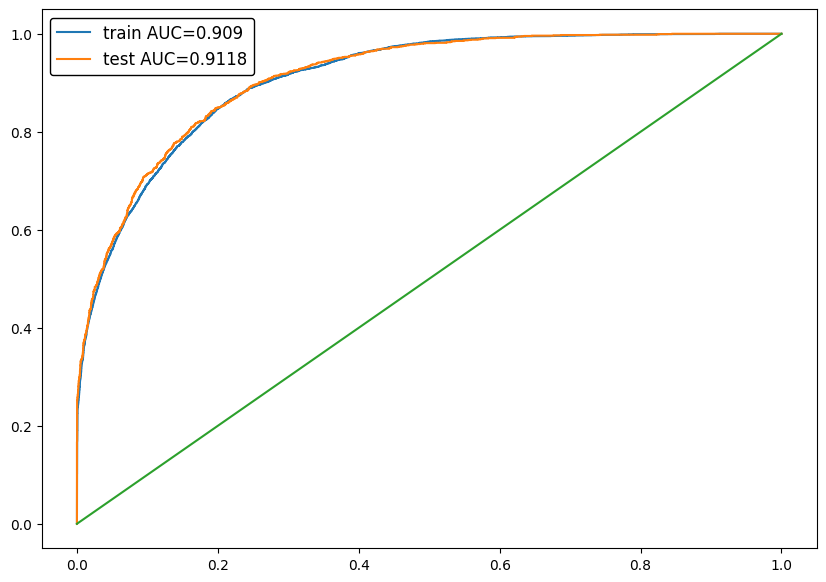

In [85]:
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
plt.plot(*roc_curve(y_train, y_train_pred)[:2], label=f'train AUC={train_auc:.4}')
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label=f'test AUC={test_auc:.4}')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

<br>
<font size=5>Бустинг</font>
<br>
<br>
Обучаем алгоритмы последовательно, каждый следующий уделяет особое внимание тем случаям, на которых ошибся предыдущий.

Как в беггинге, мы делаем выборки из исходных данных, но теперь не совсем случайно. В каждую новую выборку мы берём часть тех данных, на которых предыдущий алгоритм отработал неправильно. То есть как бы доучиваем новый алгоритм на ошибках предыдущего.
<br><br>
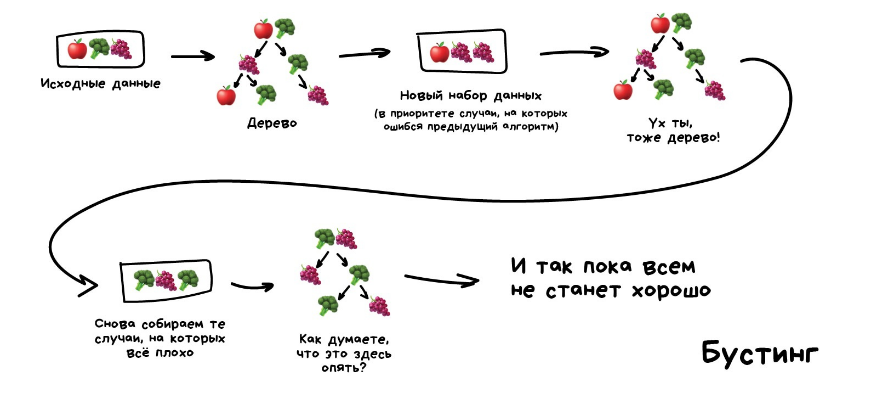
<br><br>

In [93]:
# !pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [94]:
import xgboost

In [95]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_pred = boosting_model.predict_proba(X_train)[:, 1]
y_test_pred = boosting_model.predict_proba(X_test)[:, 1]

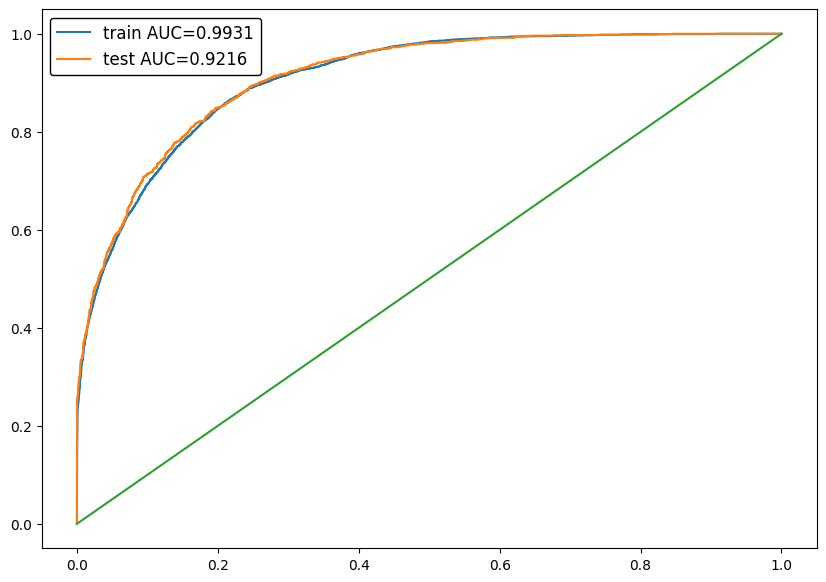

In [96]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10, 7))
plt.plot(*roc_curve(y_train, y_train_pred)[:2], label=f'train AUC={train_auc:.4}')
plt.plot(*roc_curve(y_test, y_test_pred)[:2], label=f'test AUC={test_auc:.4}')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()